# Pairing HamiltonianのQPE計算 (Pennylane)

In [1]:
import numpy as o_np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import pennylane as qml 
from pennylane import numpy as np
import openfermion as of

Hamiltonianを再掲しておこう:

$$
\begin{align}
P^{\dagger}_p & = \frac{1}{2} (X_p - iY_p) \\
P_p & = \frac{1}{2} (X_p + iY_p) \\
N_p & = \frac{1}{2} ( 1  - Z_p) \\
H & = \sum_{p} \epsilon_p N_p - g \sum_{pq} P^{\dagger}_p P_q \\
& = \sum_{p} \epsilon_p \frac{1}{2} ( 1  - Z_p) - g \sum_{pq} \frac{1}{4} (X_p - iY_p)(X_q + iY_q) \\
& = \sum_{p} \frac{\epsilon_p - g}{2} (1 - Z_p ) - \frac{g}{4} \sum_{p \neq q} (X_pX_q + Y_pY_q) \\
\end{align}
$$

In [2]:
class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = o_np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def ij_tuple_to_AdagA_str(tuple_in):
    i, j = tuple_in
    return f"{i}^ {j}"

Norb = 4
Nocc = 2
gval = 0.33  
Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals = o_np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact)

# Qubit Hamiltonian
SPEs = Hamil.epsilon
obs = [ ]
coeffs = [ ]

# 1-Zp term
for i in range(Hamil.Norb):
    op = qml.Identity(i) - qml.PauliZ(i)
    obs += [ op ]
    coeffs += [ 0.5 * (SPEs[i] - Hamil.gval) ]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(Hamil.Norb):
        if i == j:
            continue
        factor = - Hamil.gval / 4
        XX = qml.PauliX(i) @ qml.PauliX(j); obs += [ XX ]; coeffs+= [ factor ]
        YY = qml.PauliY(i) @ qml.PauliY(j); obs += [ YY ]; coeffs+= [ factor ]
H_qubit = qml.Hamiltonian(coeffs, obs)
print("H_qubit: ", H_qubit)

basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725
H_qubit:  -0.165 * (I(0) + -1 * Z(0)) + 0.835 * (I(1) + -1 * Z(1)) + 1.835 * (I(2) + -1 * Z(2)) + 2.835 * (I(3) + -1 * Z(3)) + -0.0825 * (X(0) @ X(1)) + -0.0825 * (Y(0) @ Y(1)) + -0.0825 * (X(0) @ X(2)) + -0.0825 * (Y(0) @ Y(2)) + -0.0825 * (X(0) @ X(3)) + -0.0825 * (Y(0) @ Y(3)) + -0.0825 * (X(1) @ X(0)) + -0.0825 * (Y(1) @ Y(0)) + -0.0825 * (X(1) @ X(2)) + -0.0825 * (Y(1) @ Y(2)) + -0.0825 * (X(1) @ X(3)) + -0.0825 * (Y(1) @ Y(3)) + -0.0825 * (X(2) @ X(0)) + -0.0825 * (Y(2) @ Y(0)) + -0.0825 * (X(2) 

## 時間発展演算子: $U=\exp{-i\hat{H}t}$

上のHamiltonianを少し整理して、１,2-body termで整理する:

$$
\begin{align}
\hat{H} &= 
\sum_{p} \frac{\epsilon_p - g}{2} (1 - Z_p ) - \frac{g}{2} \sum_{p > q} (X_pX_q + Y_pY_q)
\equiv H_\epsilon + H_g
\end{align}
$$

すると、first-orderのTrotter-Suzuki分解は以下のようにかける:

$$
\begin{align}
e^{-i \hat{H} t} & = 
\left(
e^{-iH_\epsilon t /r }
\prod^{N-2}_{p>q=0}
e^{\frac{igt}{2r}}
\right)
\end{align}
$$

`````{admonition} Trotter-Suzuki 
:class: tip
$H=\sum^m_{i=1} h_i$と非可換な項に分解できるとき、trotter-step $r$に対して、
first-order:

$$
e^{-iHt} = 
$$

`````

## Hadamard test



[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

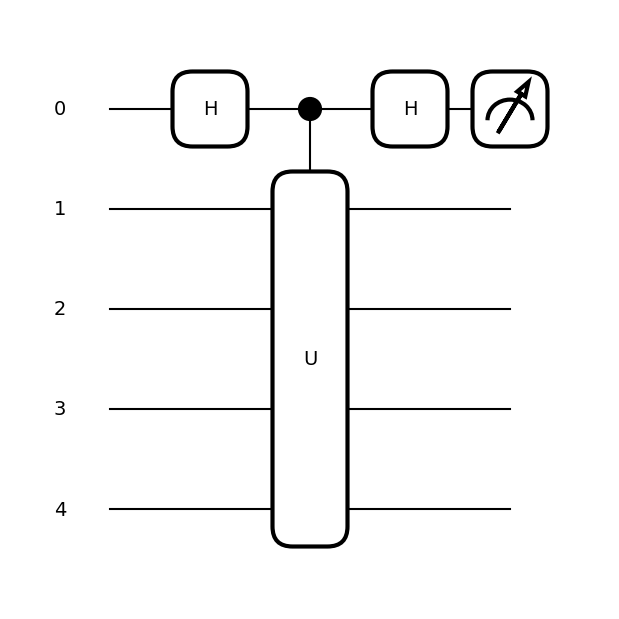

In [19]:
n_ancilla = 1
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_HadamardTest(U):
    qml.Hadamard(wires=0)
    qml.ControlledQubitUnitary(U.matrix(), control_wires=[0], wires=range(1, 1+Norb))
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

fig, ax  = qml.draw_mpl(circuit_HadamardTest)(H_qubit)

num_measurements = 10**3
results = [ circuit_HadamardTest(H_qubit).item() for _ in range(num_measurements) ]
print(results)
